# Business Problem Statement
Cookie Cats, a popular mobile puzzle game developed by Tactile Entertainment, is designed to captivate and engage players through its entertaining gameplay and strategic challenges. One critical aspect of the game’s design is the placement of gates, which are points in the game where players must wait or make in-app purchases to progress. The placement of these gates can significantly influence player retention and overall game engagement.
 
Recently, the game develowpment team at Cookie Cats has hypothesized that relocating the initial gate from level 30 to level 40 may improve player retention and engagement. To test this hypothesis, an A/B test was conducted where new players were randomly assigned to one of two groups: 

1. The control group with the gate at level 30 (gate_30)
2. The experimental group with the gate moved to level 40 (gate_40).

The primary objective of this analysis is to determine whether moving the gate to level 40 has a positive impact on player behavior, specifically focusing on key metrics such as the number of game rounds played within the first 14 days (sum_gamerounds) and retention rates at one day (retention_1) and seven days (retention_7) after installation.

# Data

The data we have is from **90,189 players** that installed the game while the AB-test was running. The variables are:

1. *userid*: A unique number that identifies each player.
2. *version*: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
3. *sum_gamerounds*: the number of game rounds played by the player during the first 14 days after install.
4. *retention_1*: Did the player come back and play 1 day after installing?
5. *retention_7*: Did the player come back and play 7 days after installing?


In [107]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
import arviz as az

from dataclasses import dataclass


In [111]:

plt.style.use("bmh")
plt.rcParams['figure.figsize'] = [10, 5] 

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
)

In [97]:
data = pd.read_csv("data/cookie_cats.txt")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [98]:
data.groupby(["version"])["sum_gamerounds"].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


Text(0, 0.5, 'Retention Rate')

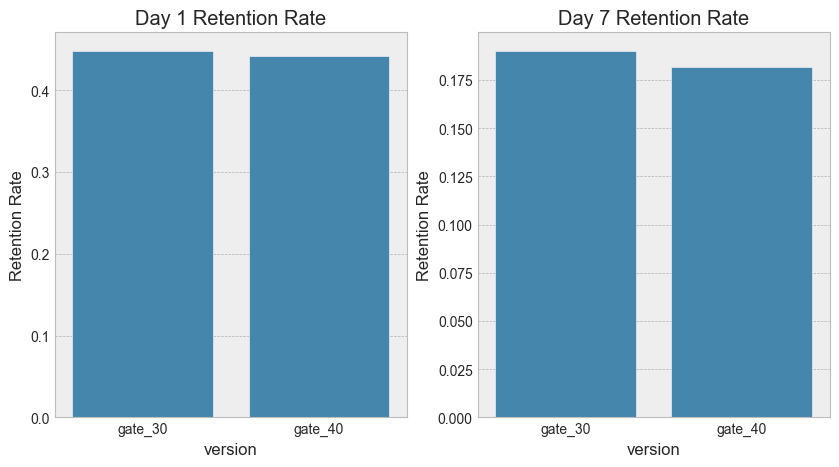

In [99]:
retention_rates = data.groupby("version")[["retention_1", "retention_7"]].mean().reset_index()

fig, ax = plt.subplots(1, 2)

sns.barplot(x="version", y="retention_1", data=retention_rates, ax=ax[0])
ax[0].set_title('Day 1 Retention Rate')
ax[0].set_ylabel('Retention Rate')

sns.barplot(x="version", y="retention_7", data=retention_rates, ax=ax[1])
ax[1].set_title('Day 7 Retention Rate')
ax[1].set_ylabel('Retention Rate')

<Axes: xlabel='version', ylabel='count'>

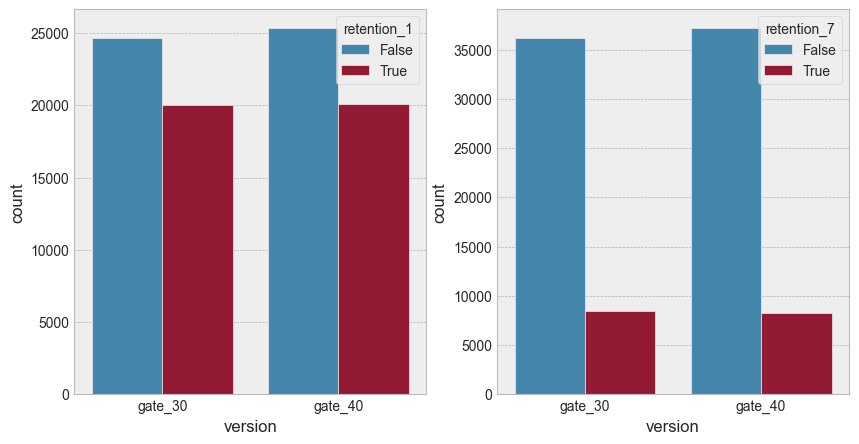

In [100]:
plt.subplot(1, 2, 1)
sns.countplot(data=data, x="version", hue="retention_1")
plt.subplot(1, 2, 2)
sns.countplot(data=data, x="version", hue="retention_7")

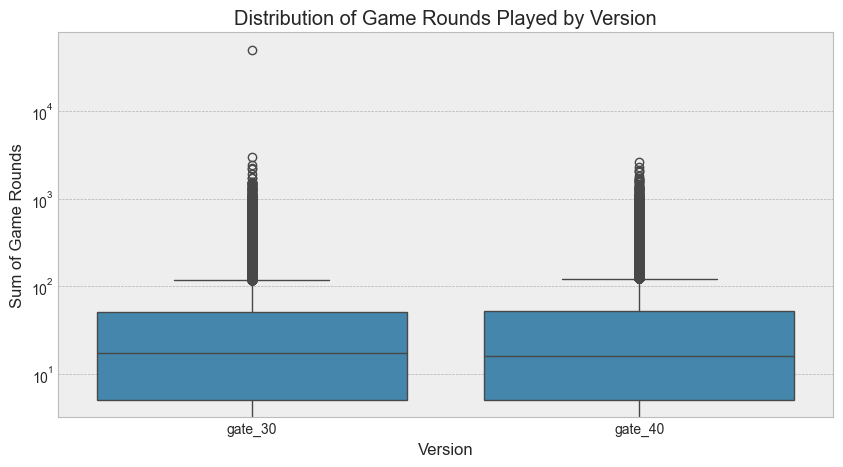

In [101]:
sns.boxplot(x="version", y="sum_gamerounds", data=data)
plt.title('Distribution of Game Rounds Played by Version')
plt.xlabel('Version')
plt.ylabel('Sum of Game Rounds')
plt.yscale('log')
plt.show()

We seem to have some heavy outliers.


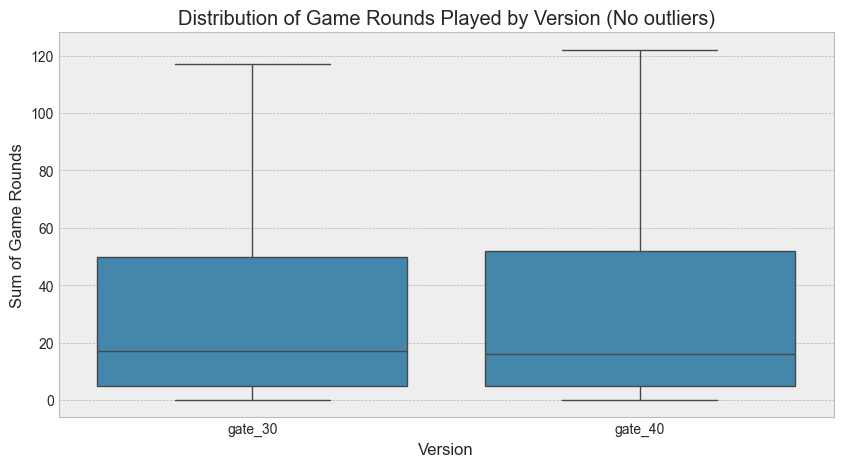

In [102]:
sns.boxplot(x="version", y="sum_gamerounds", data=data, showfliers=False)
plt.title('Distribution of Game Rounds Played by Version (No outliers)')
plt.xlabel('Version')
plt.ylabel('Sum of Game Rounds')
# plt.yscale('log')
plt.show()

# Analysis

We first tackle the metrics of `retention_1` and `retention_2`. These can be modeled as *bernoulli conversions*, where the parameter of interest is the user performing an action. In this case, these actions are:

1. rention_1: Did the player come back and play 1 day after installing?
2. rention_7: Did the player come back and play 7 days after installing?

What we want to know is whether `gate_30` is "better" than `gate_40`. Let $\theta_{30}$ and $\theta_{40}$ be the true conversion rates for each version respectively. Then the outcome of whether a player converts (that is, come back to play 1 or 7 day after installing the game) is the random variable $Bernoulli(\theta_{30})$ and $Bernoulli(\theta_{40})$. And if we assume that the player's behaviors are independent of other players (a fair assumption), then the total conversions $y$ for a version has the Binomial distribution:
$$
y \sim  \sum^N Bernoulli(\theta) = Binomial(N, \theta)
$$

## Setting the Priors
Since we cannot know the true conversion rates, we model specify them using the *Beta distribution*. 

> Those familiar with Bayesian inference will notice why this is convenient. The Beta distribution is the conjugate prior of the Binomial, so we can get the posterior analytically. We will still use sampling using `PyMC` as this makes it easier to extend the model with different priors and assumptions.

Since we don't have any prior knowledge or the contet of the proble, we chose a non-informative prior $Beta(1, 1)$. $Beta(1, 1)$ is also known as the uniform distribution on the interval [0, 1]. Since conversion rates are probablities of players returning to the game, they must lie within [0, 1].


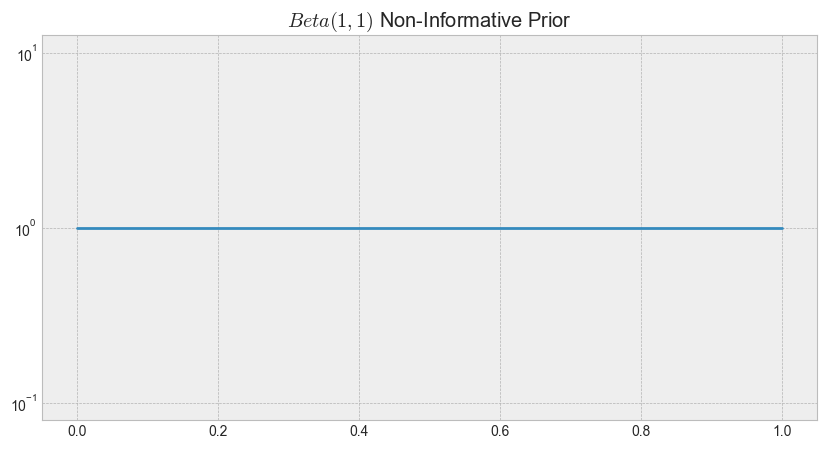

In [103]:
plt.figure()
pz.Beta(alpha=1, beta=1).plot_pdf(legend=False)
plt.title("$Beta(1, 1)$ Non-Informative Prior")
plt.yscale('log')

### How do we chose priors?
A prior is what you believe *before you have any evidence*. There is usually no (loaded word alert) *objective* basis for choosing a prior. In practice, it depends on the broader context. Has the company run previous experiments? If so, we could use these to inform our priors. A weakly informative prior can be used when we have some information but want to the data to play a dominant role. That is, we provide a slight guidance without overwhelming the data. If on the other hand, we have substantial prior knowledge from past data or expert opinions, then we could provide a strongly informative prior. This will safe gaurd against false discoveries but may require more data to detect winning variants when they exist (also, more data = longer time required running the test).

### Emperical Bayes Method
> To be explored later

## Relative Uplift
Since we are interested in whether `gate_30` is better than `gate_40`, we use the relative uplift in conversion rates:
$$
\text{uplift}_{30} = \frac{\theta_{30}}{\theta_{40}} - 1 
$$

## Modeling


In [104]:
@dataclass
class BetaPrior:
		alpha: float
		beta: float


# separate the two versions into separate  vectors
# extract vectors for gate_30
retention_1_gate_30_a = (
		data.query("version == 'gate_30'")["retention_1"].astype(int))

retention_7_gate_30_a = (
		data.query("version == 'gate_30'")['retention_7'].astype(int).values)

# extract vectors for gate_40
retention_1_gate_40_a = (
		data.query("version == 'gate_40'")['retention_1'].astype(int).values)

retention_7_gate_40_a = (
		data.query("version == 'gate_40'")['retention_7'].astype(int).values)

retention_1_gate_30_a

0        0
1        1
6        0
11       0
13       1
        ..
90179    1
90180    0
90182    1
90183    0
90186    1
Name: retention_1, Length: 44700, dtype: int64

### Retention 1


In [105]:
prior = BetaPrior(alpha=1, beta=1)

with pm.Model() as model:
	p_30 = pm.Beta('p_30', alpha=prior.alpha, beta= prior.beta)
	p_40 = pm.Beta('p_40', alpha=prior.alpha, beta= prior.beta)

	obs_30 = pm.Bernoulli('obs_30', p=p_30, observed=retention_1_gate_30_a)
	obs_40 = pm.Bernoulli('obs_40', p=p_40, observed=retention_1_gate_40_a)

	uplift_b = pm.Deterministic('uplift_b', p_30 / p_40 - 1)

	idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_30, p_40]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 40 seconds.


array([[<Axes: title={'center': 'p_30'}>,
        <Axes: title={'center': 'p_30'}>],
       [<Axes: title={'center': 'p_40'}>,
        <Axes: title={'center': 'p_40'}>],
       [<Axes: title={'center': 'uplift_b'}>,
        <Axes: title={'center': 'uplift_b'}>]], dtype=object)

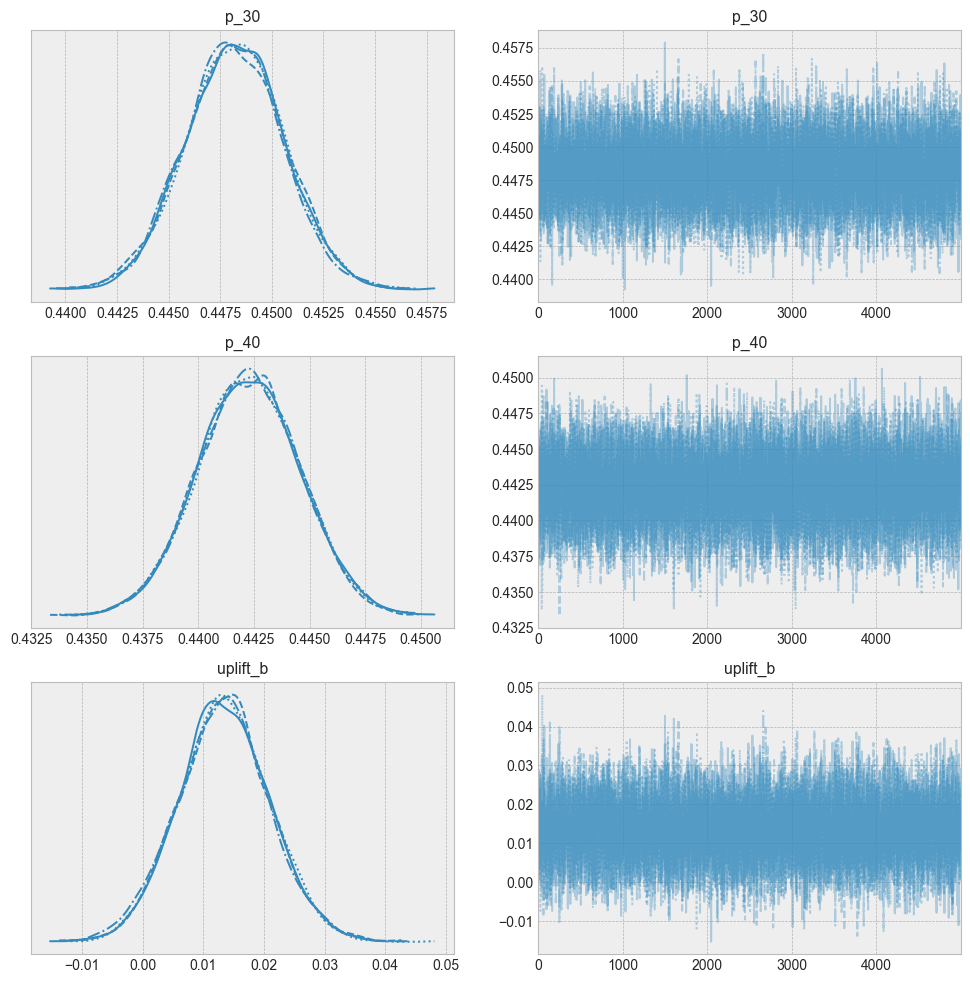

In [113]:
az.plot_trace(idata, figsize=(12, 12))

<Axes: title={'center': 'uplift_b'}>

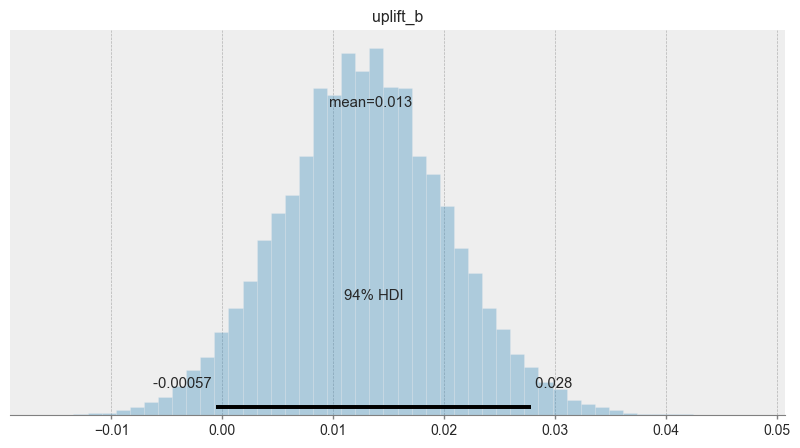

In [115]:
az.plot_posterior(idata.posterior["uplift_b"], **plotting_defaults)